In [1]:
import ta
from ta.volume import VolumeWeightedAveragePrice
from datetime import datetime
import pdmongo as pdm
import pandas as pd
import numpy as np

from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection    import train_test_split

import matplotlib.pyplot as plt
import pickle

from polaristools.polarisbot import PolarisBot

# Inputa data

In [ ]:
polaris = PolarisBot()

## Main instrument

In [ ]:
filename = 'df_'

In [4]:
df = polaris.dataframeFromBinary(filename)

## Secondary or comparative

In [ ]:
# 

# Technical indicators

In [4]:
def apply_technicals(df):
    for i in range(10,101,10):
        df['SMA_'+str(i)] = df.close.rolling(i).mean()
    for j in range(15,101,5):
        df['rsi_'+str(j)] = ta.momentum.rsi(df.close, window=j)
    df['macd'] = ta.trend.macd_diff(df.close)
    df.dropna(inplace=True)

In [5]:
apply_technicals(df)

In [6]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_20', 'SMA_30',
       'SMA_40', 'SMA_50', 'SMA_60', 'SMA_70', 'SMA_80', 'SMA_90', 'SMA_100',
       'rsi_15', 'rsi_20', 'rsi_25', 'rsi_30', 'rsi_35', 'rsi_40', 'rsi_45',
       'rsi_50', 'rsi_55', 'rsi_60', 'rsi_65', 'rsi_70', 'rsi_75', 'rsi_80',
       'rsi_85', 'rsi_90', 'rsi_95', 'rsi_100', 'macd'],
      dtype='object')

In [7]:
def vwap(dataframe, label='vwap', window=1, fillna=True):
        dataframe[label] = VolumeWeightedAveragePrice(
                high=dataframe['high'],
                low=dataframe['low'],
                close=dataframe["close"],
                volume=dataframe['volume'],
                window=window,
                fillna=fillna
        ).volume_weighted_average_price()
        dataframe.dropna(inplace=True)
        return dataframe

In [9]:
df = vwap(dataframe=df, label='vwap24',window=24)

In [ ]:
df.info()

In [17]:
df[['close','vwap24']].tail()

,close,vwap24
open_time,,
2022-07-21,23152.19,21202.237335
2022-07-22,22684.83,21297.367927
2022-07-23,22451.07,21360.413988
2022-07-24,22579.68,21444.612963
2022-07-25,21310.90,21509.895822


## Compared instrument

In [ ]:
# btc_df = makeFeed(pair='btc', timeframe='1h')
# btc_df['pct_change'] = btc_df.close.pct_change()
# btc_df = btc_df['pct_change']
# # df_btc_sample = btc_df.loc['2018':'2019']
# # btc_df
# df['btc_pctCHange'] = btc_df
# df.dropna(inplace=True)
# # df


# Define independent variables and dependent variable.

In [18]:
def x_y(df, period):
    '''
        Independent variable X is the dataset.
        Dependent variable Y is a numpy array of 0 and 1's as a binary classification,
            based on the direction of the market at the previous close.
    '''
    y = df.close.shift(-period) - df.close
    y = y[:-period]
    x = df[:-period]
    y = np.where(y > 0, 1, 0)
    return x,y

In [19]:
x,y = x_y(df, 1)

# Train test split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.4,
                                                    random_state=1722,
                                                    shuffle=False)

# <center>Instantiate Classifier

In [28]:
rf_clf = RandomForestClassifier(random_state=1722)

## <center>Classifier.fit

In [29]:
rf_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=1722)

## Evaluate

In [30]:
predictor = rf_clf.predict(x_test)

### Persist object-model as a binary.

In [ ]:
filename = 'randomforestcl-btcusdt-1d'

In [49]:
with open(f'trained-models/{filename}.pckl', 'wb') as bin_trainedmodel:
    pickle.dump(rf_clf, bin_trainedmodel)

### Retrieve model from file.

In [6]:
filename = 'randomForestClf-btc1h'

In [51]:
bin_model = open(f'trained-models/{filename}.pckl', 'rb')
rf_clf_trained = pickle.load(bin_model)
bin_model.close()

# Results

SKLearn Confusion matrix:<br><br>
[True negative][False positive]<br>
[False negative][True positive]

In [42]:
matrix = confusion_matrix(y_test, predictor)

In [43]:
print(matrix)

[[290  41]
 [295  56]]


In [41]:
results = f"""RESULTS______________
Assert on Sells : {matrix[0,0]}
Failed Sells    : {matrix[1,0]}

Assert on Buys  : {matrix[1,1]}
Failed Buys     : {matrix[0,1]}
"""

print(results)

RESULTS______________
Assert on Sells : 290
Failed Sells    : 295

Assert on Buys  : 56
Failed Buys     : 41



In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, predictor).ravel()

In [ ]:
accuracy_score = float(accuracy_score( y_test, predictor))
precision_score = float(precision_score( y_test, predictor))
print(f'accuracy_score : {accuracy_score:.3}\nprecision_score : {precision_score:.3}')

In [46]:
precision_score(y_test, predictor)

0.5773195876288659

## <center>Predict on new data

In [58]:
df = polaris.createDataframe(
    mydb='binance_spot_margin_usdt',
    collection='klines_ADAUSDT_1d',
)

apply_technicals(df)
df = vwap(dataframe=df, label='vwap24',window=24)
x,y = x_y(df, 1)

In [59]:
new_prediction = rf_clf_trained.predict( x )

In [61]:
matrix_i = confusion_matrix( y, new_prediction)

print(matrix_i)

[[226 496]
 [213 526]]


In [78]:
results = f"""RESULTS______________
Assert on Sells : {matrix_i[0,0]}
Failed Sells    : {matrix_i[1,0]}

Assert on Buys  : {matrix_i[1,1]}
Failed Buys     : {matrix_i[0,1]}
"""

print(results)

RESULTS______________
Assert on Sells : 226
Failed Sells    : 213

Assert on Buys  : 526
Failed Buys     : 496



In [62]:
tn, fp, fn, tp = confusion_matrix( y, new_prediction).ravel()

In [73]:
accuracy_score = float(accuracy_score( y, new_prediction))
precision_score = float(precision_score( y, new_prediction))
print(f'accuracy_score : {accuracy_score:.3}\nprecision_score : {precision_score:.3}')

In [166]:
# ITERATION WITH LOOKBACK PERIOD
    # with '1h' timeframe lookback period about 650 is better

results = []
for i in range(10,700,10):
    x,y = x_y(df, i)
    prediction = rf_clf_trained.predict( x )
    cm = confusion_matrix( y, prediction)
    tn, fp, fn, tp = confusion_matrix( y, prediction).ravel()
    results.append(
        [
        i,
        accuracy_score( y, prediction),
        precision_score( y, prediction)
        ]
    )

results.sort(key=lambda r:r[1], reverse=True)
results[:5]

[[10, 0.49564146602287823, 0.4956862745098039],
 [20, 0.49411650296606047, 0.4942137953579601],
 [30, 0.4883102564934012, 0.48790058862001306],
 [50, 0.48444141600960444, 0.48444095415725924],
 [60, 0.48193709630302833, 0.48165362835913716]]

# Plot

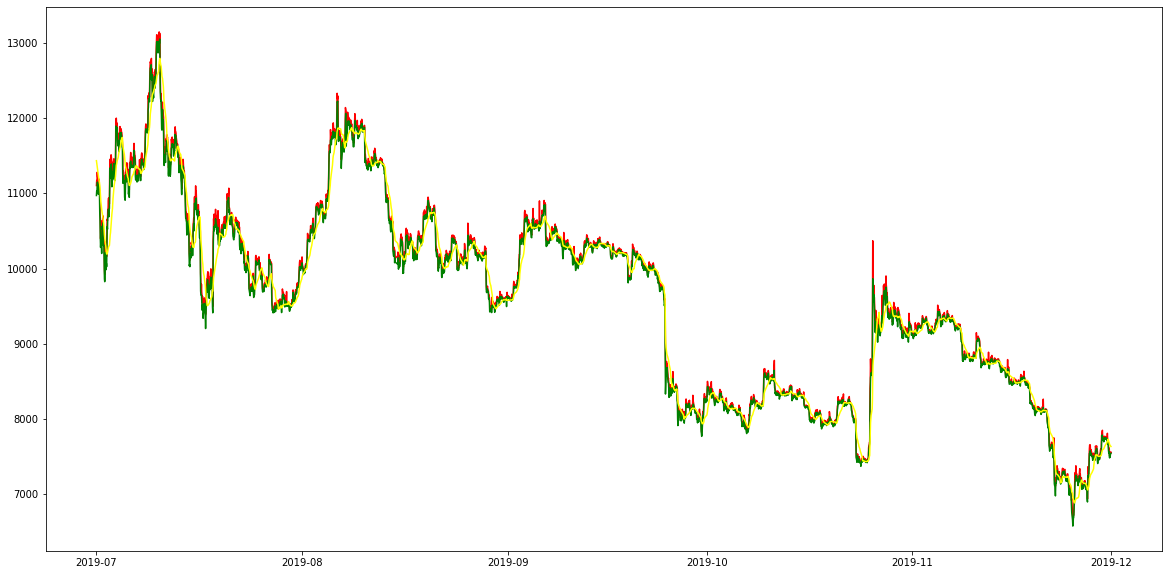

In [200]:
fig, ax = plt.subplots(figsize=(20,10))
# fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

ax.plot( df.loc['2019-07':'2019-11']['high'], color='red' )
ax.plot( df.loc['2019-07':'2019-11']['vwap'], color='green' )
ax.plot( df.loc['2019-07':'2019-11']['vwap24'], color='yellow' )

plt.show()